In [64]:
#importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

In [65]:
freq_data, flux_data = np.loadtxt("/home/mher/Desktop/data_synchrotron.txt",unpack = True ) #reading a data from synchrotron data file


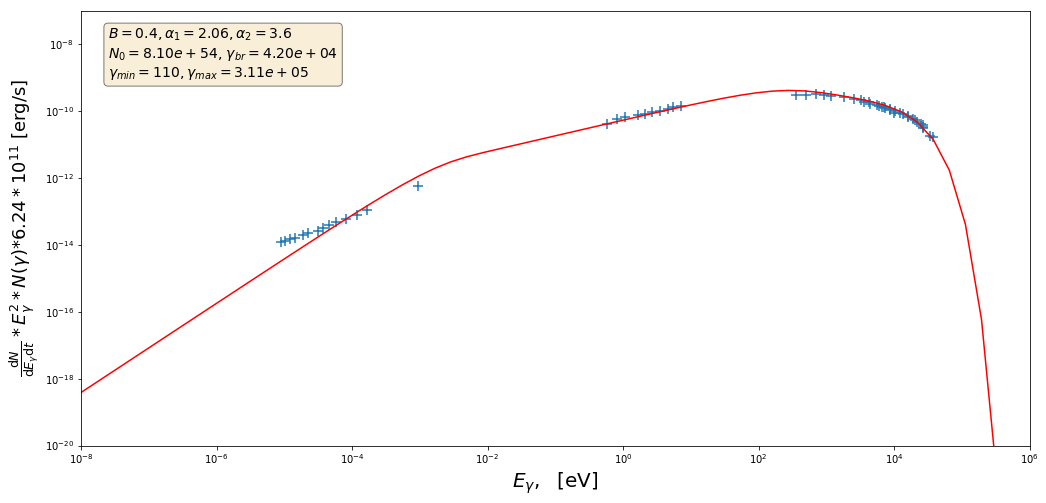

In [68]:
############ defining constants
q = 4.8032 * 10**-10  #Electron charge, g**(1/2)*cm**(3/2)*s**-1
h = 6.5821* 10**-16   #Planck constants h bar, Ev*s
m = 9.1095 * 10**-28  #Electron mass, g
c = 2.9979 * 10**10   #Light speed, cm*s-1
mcsquare = 511000     #0.511 MeV electrons rest energy
hev = 4.135667662*10**-15 #Plank's constant in eV
ergtoev = 6.24*10**11 #eV
evtoerg = 0.16*10**-11 #erg
distance = 1.88274 * 10**28 #Distance Earth and object
hev = 4.135667662*10**-15 #Plank's constant in eV
delta = 18            #Doppler and Lorenz factor
gamma_br = 4.2*10**4
#############################
Eg_data = freq_data * hev #converting frequnecy to energy
###############Functions
F = lambda x: 2.15*x**(1/3)*(1+3.06*x)**(1/6)*(1+0.884*x**(2/3)+0.471*x**(4/3))*np.exp(-x) \
    /(1+1.64*x**(2/3)+0.974*x**(4/3)) #Bessel function
Ec = lambda gamma,B: 3*q*h*B*gamma**2/(2*m*c)  ##Measurment is eV, characteristic energy
Energy = lambda Eg,B,gamma:  3**0.5*q**3*B/(2*np.pi*mcsquare*h*Eg)*F(Eg/Ec(gamma,B)) #Eg is a photon energy

def ElectronDist(gamma, alpha1, alpha2,N0):  ###Electron distribution, broken law
    if gamma<gamma_br:
        return N0*gamma**(-alpha1)
    elif gamma >= gamma_br:
        return N0*gamma_br**(alpha2-alpha1)* gamma**(-alpha2)

EnergySyn_subintegral =  lambda j,Eg,B,alpha1,alpha2,N0: 10**j*np.log(10) * Energy(Eg,B,10**j) *ElectronDist(10**j,alpha1,alpha2,N0)   ## 10**j in subtituted \
                                                                                                  #for gamma
EnergySyn = lambda Eg,B,alpha1,alpha2,N0,gamma_min,gamma_max: quad( EnergySyn_subintegral, np.log10(gamma_min), \
                              np.log10(gamma_max), args=(Eg,B,alpha1,alpha2,N0), limit = 50)[0] #Energy of all photons combined

Luminosity= lambda Eg,B,alpha1,alpha2,N0,gamma_min,gamma_max: Eg**2* EnergySyn(Eg,B,\
                                                            alpha1,alpha2,N0,gamma_min, \
                                                                        gamma_max) #Luminosity of the object
FluxInOurSystem= lambda Eg,B,alpha1,alpha2,N0,gamma_min,gamma_max: delta**4 /(4*np.pi*distance**2) * \
                    Luminosity(Eg/delta,B,alpha1,alpha2,N0,gamma_min,gamma_max) * 1/evtoerg #We convert Flux, 

                                                                #by brining it in our system via Lorenz transformations


###############################################
#Visualisation and fiting of the  data

#####Optimal parameters of fit
B_fit = 0.4
alpha1_fit = 2.06
alpha2_fit = 3.6
N0_fit = 8.1*10**54
gamma_min_fit = 110
gamma_max_fit = 3.11*10**5
####################
Eg_val = np.logspace(-8,6,  num=60) #logarithmical values of E_gamma's , our plot scale is loglog
FluxInOurSystem_vals = np.array([FluxInOurSystem(i,B_fit,alpha1_fit,alpha2_fit,N0_fit,gamma_min_fit,gamma_max_fit) \
                                 for i in Eg_val])  #Y axes values, for given optimal parameters

#######Ploting
fig, ax = plt.subplots(figsize = (17,8)) # creating figure

ax.scatter(Eg_data, flux_data, marker = "+", s = 90)  #scatter plot of data

#adjusting axes 
ax.set_xlabel(r"$E_{\gamma}, \ \ [\mathregular{eV}]$", fontsize = 20)
ax.set_ylabel(r'$\frac{ \mathregular{d}N}{\mathregular{d}E_\gamma \mathregular{d}t}* E_\gamma ^{2} * N(\gamma)$' 
              + r'$*6.24*10^{11}$ [erg/s]', fontsize = 18)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(10**-8,10**6)
ax.set_ylim(10**-20,10**-7)

#adding text to the plot
plot_text = r"$B= {},$".format(B_fit) + r"$\alpha_{{1}} = {},$".format(alpha1_fit) + \
    r"$\alpha_{{2}} = {}$".format(alpha2_fit)+ "\n"+ r"$N_{{0}} = {:.2e}$, $\gamma_{{br}} = {:.2e}$".format(N0_fit,gamma_br ) \
    + \
    "\n" + r"$\gamma_{{min}} = {}, \gamma_{{max}} = {:.2e}$".format(gamma_min_fit,gamma_max_fit)
bbox_params = dict(boxstyle= "round", facecolor= "wheat", alpha=0.5)
ax.text(0.25*10**-7,10**-9, plot_text, bbox = bbox_params, fontsize = 14)
#ploting fiting function

ax.plot(Eg_val,FluxInOurSystem_vals,c = 'r')

#showing and saving the plot
plt.savefig("/home/mher/Desktop/Synchrotron Fit_low magnetic field.pdf", dpi= 300)
plt.show()